# Final Project Medical Imaging
Alejandro Cedillo Gamez

In [1]:
import os
import pydicom
import numpy as np

### Instructions:
__1) Load the reference CT image (pydicom) and the associated segmentations (highdicom).
Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers__

__2)Create an animation (e.g. gif file) with a rotating Maximum Intensity Projection on the
coronal-sagittal planes, visualizing the tumoral mask.__

## Cancer segmentation rotation gif
Steps:
1) Get the ct_volume -> the CT numpy array
2) Get the tumor and liver mask -> same patient, same shape
3) Generate 3D projections from masks and ct volume

### CT volume

In [ ]:
# data folder with DICOM files
ct_folder = "1196/  /"

Load every CT slice DICOM with pydicom, sort them by their real-world Z-position, and stack into an array

In [11]:
# Load DICOM files
files = [os.path.join(ct_folder, f) for f in os.listdir(ct_folder)]
datasets = []
for f in files:
    try:
        ds = pydicom.dcmread(f)
        # img slices only
        if hasattr(ds, "PixelData"):
            datasets.append(ds)
    except Exception as e:
        # the rest we skip
        continue

# Sort by the Z coordinate 
datasets.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))

# Stack into a 3D NumPy array
ct_slices = [ds.pixel_array for ds in datasets]
ct_volume = np.stack(ct_slices, axis=0)  # (num_slices, rows, cols)

# Record slice positions for later
z_positions = [float(ds.ImagePositionPatient[2]) for ds in datasets]

print(f"Loaded CT volume with shape {ct_volume.shape}")


Loaded CT volume with shape (52, 512, 512)


In [18]:
print(ds.dir())

['AccessionNumber', 'AcquisitionDate', 'AcquisitionNumber', 'AcquisitionTime', 'AcquisitionUID', 'BitsAllocated', 'BitsStored', 'Columns', 'ContentDate', 'ContentTime', 'ConvolutionKernel', 'DataCollectionDiameter', 'DeidentificationMethod', 'DeidentificationMethodCodeSequence', 'ExposureTime', 'FillerOrderNumberImagingServiceRequest', 'FrameOfReferenceUID', 'GantryDetectorTilt', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'ImageType', 'InstanceCreationDate', 'InstanceCreationTime', 'InstanceNumber', 'KVP', 'LongitudinalTemporalInformationModified', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'NumberOfFrames', 'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientIdentityRemoved', 'PatientName', 'PatientPosition', 'PatientSex', 'PhotometricInterpretation', 'PixelData', 'PixelRepresentation', 'PixelSpacing', 'PositionReferenceIndicator', 'ProcedureCodeSequence', 'ReconstructionDiameter', 'ReferringPhysicianName', 'RescaleIntercept', 'RescaleSlope', 'RescaleTy

In [12]:
labels = ds.pixel_array

# list all unique label values
uniques = np.unique(labels)
print("Unique labels in SEG:", uniques)

Unique labels in SEG: [-1024 -1023 -1022 ...  1618  1673  1728]


### Tumor and liver masks

In [13]:
# Load the segmentation files
tumor_file = "1196/10_AP_Ax5.00mm_ManualROI_Tumor.dcm"
liver_file = "1196/10_AP_Ax5.00mm_ManualROI_Liver.dcm"

In [14]:
# helper to build a 3D boolean mask volume from a DICOM-SEG file
def build_mask_volume(seg_file, ct_z_positions, ct_shape):
    ds = pydicom.dcmread(seg_file)
    frames = ds.pixel_array                     # (F, Y, X)
    frame_zs = [
        float(f.PlanePositionSequence[0].ImagePositionPatient[2])
        for f in ds.PerFrameFunctionalGroupsSequence
    ]

    # empty mask volume
    mask_vol = np.zeros(ct_shape, dtype=bool)  # same shape as ct_volume
    ct_z = np.array(ct_z_positions)
    for f, z in enumerate(frame_zs):
        # find the closest slice in the CT volume
        idx = int(np.argmin(np.abs(ct_z - z)))
        # assign the mask
        mask_vol[idx] = frames[f] > 0
    return mask_vol


mask_tumor = build_mask_volume(tumor_file, z_positions, ct_volume.shape)
mask_liver = build_mask_volume(liver_file, z_positions, ct_volume.shape)

In [15]:
import scipy
# copied functions from the activity 3 notebook
def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)


### Visualize tumor data

In [19]:
seg_ds = pydicom.dcmread(tumor_file)

# Extract the raw mask frames
# we get (num_frames, rows, cols)
mask_array = seg_ds.pixel_array  
print("Mask array shape:", mask_array.shape)
print("Unique values in mask:", np.unique(mask_array))

# Get each frame’s slice location (Z‑position)
frame_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in seg_ds.PerFrameFunctionalGroupsSequence
]
print("First 5 frame Z‑positions:", frame_positions[:5])

Mask array shape: (19, 512, 512)
Unique values in mask: [0 1]
First 5 frame Z‑positions: [-182.0, -162.0, -157.0, -152.0, -147.0]


In [20]:
# Make an empty volume the same shape as ct_volume
mask_volume = np.zeros_like(ct_volume, dtype=bool)

In [21]:
# Convert z_positions to a NumPy array for better handling
ct_z = np.array(z_positions)

for f, frame_z in enumerate(frame_positions):
    # Find the CT slice whose Z is closest to this frame's Z
    slice_idx = int(np.argmin(np.abs(ct_z - frame_z)))
    # Insert this 2D mask into that slice
    mask_volume[slice_idx, :, :] = mask_array[f] > 0  # True where tumor


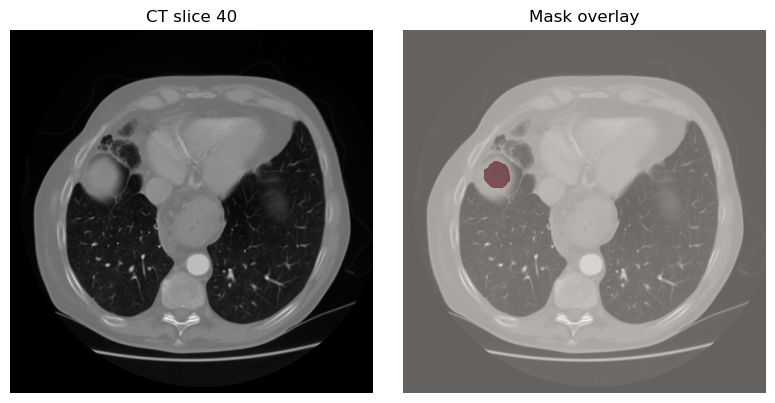

In [ ]:
# Visualization of data
import matplotlib.pyplot as plt
import numpy as np

z0 = slice_idx  

ct_slice  = ct_volume[z0]
mask_slice = mask_volume[z0]  

plt.figure(figsize=(8,4))

# Plot the CT 
plt.subplot(1,2,1)
plt.title(f"CT slice {z0}")
plt.imshow(ct_slice, cmap='gray')
plt.axis('off')

# Plot CT with mask in red
plt.subplot(1,2,2)
plt.title("Mask overlay")
plt.imshow(ct_slice, cmap='gray')
plt.imshow(mask_slice, cmap='Reds', alpha=0.4)  
plt.axis('off')
plt.tight_layout()
plt.show()


### 3D projections
Now we have correctly built the mask from the tumor and livers, this with the help of the ct files, now we need to generate the projections in 3D of the patient and make it look like its spinning so we are gonna work with degrees in a rotation view series and work with each frame to overlay them with the masks 

In [ ]:
# Get a set of angles from 360 to get the images on  a number of setps
# on each one of them we do 2 operations, rotate on axial plane and MIP saggital plane.
angles = np.linspace(0, 360, num=36, endpoint=False)

projections = []
for angle in angles:
    ct_rot   = rotate_on_axial_plane(ct_volume,   angle)
    liv_rot  = rotate_on_axial_plane(mask_liver, angle)
    tum_rot  = rotate_on_axial_plane(mask_tumor, angle)

    proj_ct    = MIP_sagittal_plane(ct_rot)
    proj_liver = MIP_sagittal_plane(liv_rot) > 0
    proj_tumor = MIP_sagittal_plane(tum_rot) > 0

    projections.append((proj_ct, proj_liver, proj_tumor))


Saved rotating_liver_tumor.gif


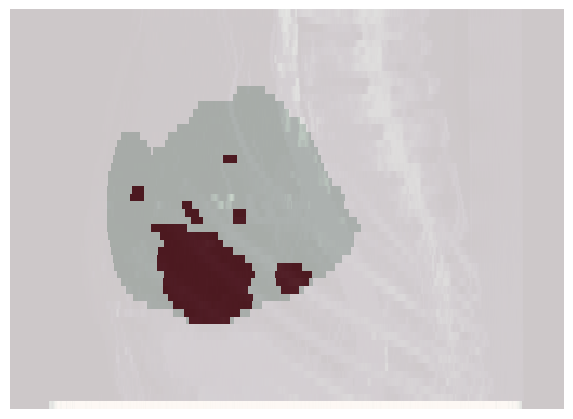

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio

os.makedirs('results/MIP', exist_ok=True)

# get display params
img_min, img_max = ct_volume.min(), ct_volume.max()
cm = plt.colormaps['bone']
slice_thick = abs(z_positions[1] - z_positions[0])
pix_spac_x, _ = datasets[0].PixelSpacing
aspect = slice_thick / pix_spac_x

# prepare figure for animation
fig, ax = plt.subplots(figsize=(6,4))
ax.axis('off')
plt.tight_layout(pad=0)

frames = []
for proj_ct, proj_liver, proj_tumor in projections:
    im_ct = ax.imshow(proj_ct,
                     cmap=cm,
                     vmin=img_min, vmax=img_max,
                     aspect=aspect,
                     interpolation='nearest',
                     animated=True)
    im_liv = ax.imshow(proj_liver,
                       cmap='Greens',
                       alpha=0.4,
                       aspect=aspect,
                       interpolation='nearest',
                       animated=True)
    im_tum = ax.imshow(proj_tumor,
                       cmap='Reds',
                       alpha=0.6,
                       aspect=aspect,
                       interpolation='nearest',
                       animated=True)
    frames.append([im_ct, im_liv, im_tum])

anim = animation.ArtistAnimation(fig, frames, interval=100, blit=True)
anim.save('results/MIP/rotating_liver_tumor.gif', dpi=150)
print("Saved rotating_liver_tumor.gif")
